In [1]:
import os
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

from utils_old.process_muac_audio import list_years, list_months, list_days, list_audio_one_day 
from utils_old.process_muac_audio import build_audio_catalog, vad_split_segments, diarize_audio, transcribe_catalog
from utils.cs_matching import build_timestamp_range, closest_callsign_at_time

from pyannote.audio import Pipeline
diarization_pipline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=os.getenv("HUGGINGFACE_TOKEN"))
#NB: can add min/max speakers and overlap = True

base_dir = "/store/kruu/atc_muac/rtl_sdr_recorded"

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1+cu126. Bad things might happen unless you revert torch to 1.x.


/home/kruu/git_folder/atc_clearences/.venv/lib/python3.12/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


TO DO: 
- Implement diarization on top on vad for each ATC communication -> Done
- Try to leverage the fact that there is always a question + answering that are closely followed. 
- Test models from TU Delft for transcription -> Don't work as good as jacktol:
    - https://repository.tudelft.nl/record/uuid:8e02d222-5775-441d-94d2-96c26156cf43
    - https://github.com/jlvdoorn/
    - https://huggingface.co/jlvdoorn
- Implement timestamping using mp3 name -> Done
- Modify pipeline to download ADS-B data for the MUAC Delta sector (find bounds) 
- Modify pipeline to transcript everything directly. -> Done
- Implement savong of the transcripts for caching
- Add a callsign matching selection based on timestamp of comm + timestamp of trajectory
- DELTA high: > FL365 / DELTA medium: FL335 - 365 / DELTA low: FL245 - 335

# Load Audio

In [2]:
# # --- Quick test ---

# # 1) Discover structure
# print(list_years(base_dir))              # ['2024', '2025', ...]
# print(list_months(base_dir, '2025'))       # ['07', '08', ...] (depends on your layout)
# print(list_days(base_dir, '2025','08'))    # ['23', '29', ...]


# # 2) List audio for a date
# audio_list = list_audio_one_day(base_dir, '2025', '08', '09')
# for a in audio_list:
#     print(a["name"])

In [2]:
# --- Load audio ---

start = datetime(2025, 8, 8, 14, 0, 0, tzinfo=timezone.utc)
stop  = datetime(2025, 8, 8, 15, 0, 0, tzinfo=timezone.utc)

catalog = build_audio_catalog(
    base_dir,
    ("2025","08","08"),
    sectors=["muac_delta_middle", "muac_delta_high"],
    start=start, 
    stop=stop,
    max_workers=128,         
    show_progress=True,  
)
print(len(catalog), "files downloaded")

Loading audio: 100%|██████████| 213/213 [00:00<00:00, 344.31file/s]

213 files downloaded


# Process audio

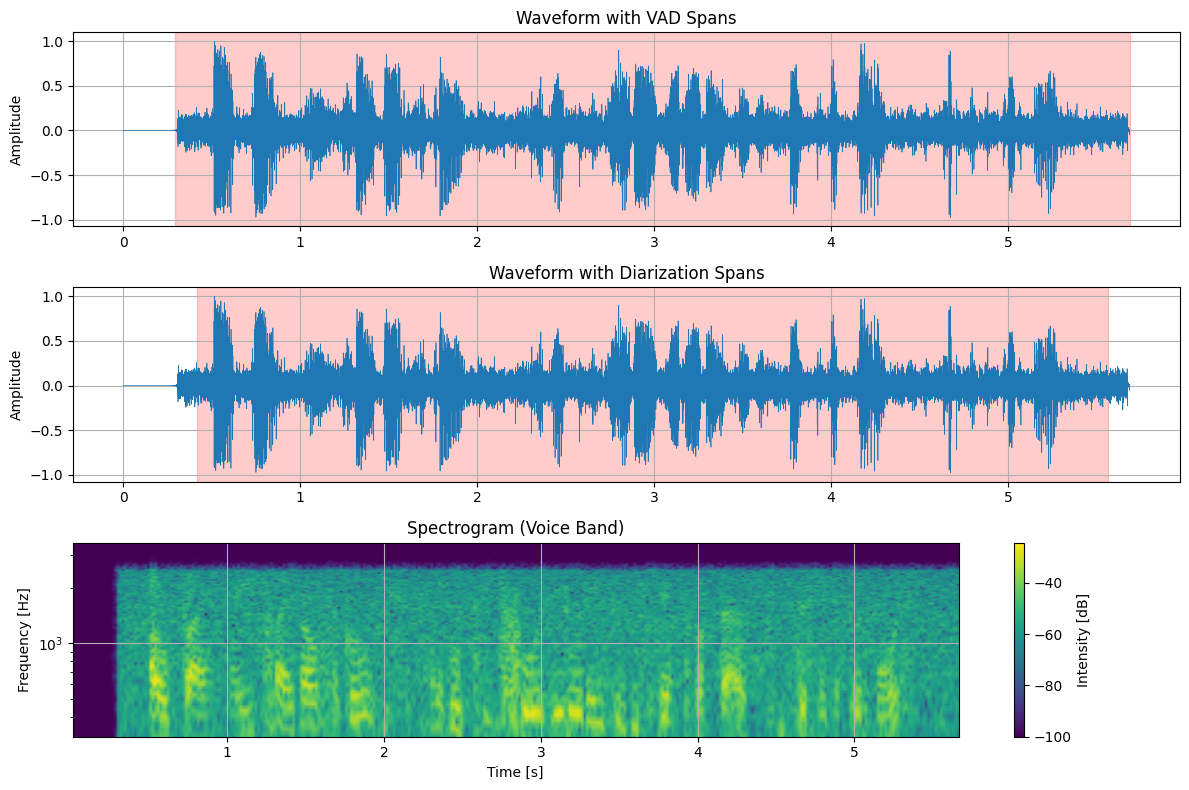

In [3]:
idx = np.random.randint(low=0, high=len(catalog))
test_audio = catalog[idx][1]
sample_rate = test_audio.frame_rate

# --- VAD ---
speech_segments_vad = vad_split_segments(
    test_audio,
    frame_duration_ms=10,
    aggressiveness=2,
    min_speech_ms=300,
)
speech_regions_vad = [(s, e) for (s, e, _) in speech_segments_vad]

# --- Diarization ---
speech_segments_diar = diarize_audio(test_audio,
                                diarization_pipline,
                                include_speaker=False)
speech_regions_diar = [(s, e) for (s, e, _) in speech_segments_diar]

# --- build samples array for plots ---
samples = np.array(test_audio.get_array_of_samples()).astype(np.float32)
# normalize for display
peak = np.max(np.abs(samples)) or 1.0
samples = samples / peak
duration = len(samples) / sample_rate

# --- spectrogram (voice band only) ---
voice_band = (300, 3500)
log_freq = True

freqs, times, Sxx = spectrogram(samples, fs=sample_rate, nperseg=512, noverlap=256)
mask = (freqs >= voice_band[0]) & (freqs <= voice_band[1])
freqs_v = freqs[mask]
Sxx_v = Sxx[mask]

# --- plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

# VAD
time_axis = np.linspace(0, duration, len(samples))
ax1.plot(time_axis, samples, linewidth=0.5)
ax1.set_title("Waveform with VAD Spans")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

for start, end in speech_regions_vad:
    ax1.axvspan(start, end, color='red', alpha=0.2)
    
# Diarization
ax2.plot(time_axis, samples, linewidth=0.5)
ax2.set_title("Waveform with Diarization Spans")
ax2.set_ylabel("Amplitude")
ax2.grid(True)

for start, end in speech_regions_diar:
    ax2.axvspan(start, end, color='red', alpha=0.2)

# spectrogram
pcm = ax3.pcolormesh(times, freqs_v, 10*np.log10(Sxx_v + 1e-10), shading="gouraud")
ax3.set_title("Spectrogram (Voice Band)")
ax3.set_ylabel("Frequency [Hz]")
ax3.set_xlabel("Time [s]")
if log_freq:
    ax3.set_yscale("log")
fig.colorbar(pcm, ax=ax3, label="Intensity [dB]")
ax3.grid(True)

# optional: highlight VAD spans on spectrogram too
# for start, end in speech_regions:
#     ax2.axvspan(start, end, color='red', alpha=0.15)

plt.tight_layout()
plt.show()

In [5]:
test_audio

# ADSB-Download

In [4]:
import re

def delete_bad_cs(flight):
    from traffic.core import Flight
    if not isinstance(flight, Flight):
        return None
    cs = flight.callsign
    icao_pattern = re.compile(r"^[A-Z]{3}[0-9]+$")
    return flight if bool(icao_pattern.match(cs.strip().upper())) else None

def above_fl(flight, alt=33000):
    from traffic.core import Flight
    if not isinstance(flight, Flight):
        return None
    df = flight.data
    if df is None or "altitude" not in df:
        return None

    # Altitude filled with na
    altitudes = df.altitude.dropna()
    if altitudes.empty:
        return None

    return flight if altitudes.mean() > alt else None

In [5]:
from ipyleaflet import Map, Polygon, LayersControl, basemaps, Rectangle
from traffic.data import eurofirs
from traffic.data import opensky
from pyopensky.schema import StateVectorsData4
from shapely.geometry import Polygon as ShapelyPolygon

dts = [meta.dt for meta, _ in catalog]
start_adsb = min(dts)
stop_adsb  = max(dts)
time_buffer = 1 # in minutes

delta_coords = [
    (53.454167, 3.606111),
    (52.733333, 5.583333),
    (52.663333, 7.168889),
    (51.193611, 5.521389),
    (51.607778, 3.171944),
    (51.480556, 3.171944),
    (51.636944, 2.500000),
    (51.455556, 2.500000),
    (51.500000, 2.000000),
    (51.950556, 2.356389)
]
delta_geom = ShapelyPolygon([(lon, lat) for lat, lon in delta_coords])

opensky_bbox = (2.000000, 51.193611, 7.168889, 53.454167)
west, south, east, north = opensky_bbox

adsb_df = opensky.history(
                start_adsb - timedelta(minutes=time_buffer),
                stop_adsb + timedelta(minutes=time_buffer),
                StateVectorsData4.baroaltitude > 10000, #in m: Get flight above FL330
                bounds=delta_geom,
            ).iterate_lazy().pipe(delete_bad_cs).assign_id().eval()

adsb_ranges = build_timestamp_range(adsb_df)

lat_center = sum(lat for lat, _ in delta_coords) / len(delta_coords)
lon_center = sum(lon for _, lon in delta_coords) / len(delta_coords)

# m = Map(center=(lat_center, lon_center), zoom=6, basemap=basemaps.OpenStreetMap.Mapnik)
m = adsb_df.map_leaflet(center=(lat_center, lon_center), zoom=6, basemap=basemaps.OpenStreetMap.Mapnik)

# Close the ring by repeating first point.
polygon = Polygon(
    locations=delta_coords + [delta_coords[0]],
    color="red",
    fill_color="red",
    fill_opacity=0.2,
    weight=3,
    name="Sector bounds"
)

bbox_rect = Rectangle(
    bounds=((south, west), (north, east)),
    color="orange",
    fill_color="orange",
    fill_opacity=0.1,
    weight=2,
    name="OpenSky bbox"
)

m.add_layer(bbox_rect) 
m.add_layer(polygon)
m.add_layer(eurofirs["EHAA"])
m.add_control(LayersControl(position="topright"))
m


Map(center=[51.9675834, 3.7579999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [6]:
adsb_ranges

,min,max
callsign,,
BAW119,2025-08-08 14:01:19+00:00,2025-08-08 14:15:20+00:00
BAW843,2025-08-08 14:14:54+00:00,2025-08-08 14:22:05+00:00
BAW869,2025-08-08 14:58:48+00:00,2025-08-08 15:00:47+00:00
BAW893,2025-08-08 14:02:27+00:00,2025-08-08 14:12:26+00:00
BAW934,2025-08-08 14:39:45+00:00,2025-08-08 14:58:40+00:00
BAW978,2025-08-08 14:57:37+00:00,2025-08-08 15:00:47+00:00
CAL081,2025-08-08 14:27:11+00:00,2025-08-08 14:39:13+00:00
CFG2402,2025-08-08 14:06:00+00:00,2025-08-08 14:26:33+00:00
CSC9610,2025-08-08 14:00:27+00:00,2025-08-08 14:04:22+00:00


# Transcribe audio

In [7]:
transcripts = transcribe_catalog(catalog, vad_split_segments)

[2025-08-08 14:01:27] passing today condor two four zero two passing three zero climbing three four zero condor two four zero two hello and climb flight level three one zero are you still looking for high
[2025-08-08 14:01:38] affirm looking for three six zero and fly heading three one zero now alfa hotel alfa we are fully above landing two nine zero
[2025-08-08 14:01:56] good day trans avia four bravo approaching two nine zero
[2025-08-08 14:02:03] confirm that me and standby higher siberia four bravo
[2025-08-08 14:02:14] four bravo
[2025-08-08 14:02:22] air to zulu alfa bravo to be sure may we control the clearance to the left main direct is that ok
[2025-08-08 14:02:31] yes me direct contrav here four bravo
[2025-08-08 14:02:35] good morning romeo juliett one two four four two zero two three zero
[2025-08-08 14:02:44] on proceed to montel five four b it is the montel de croix six zero two
[2025-08-08 14:03:14] we are juliett limi léo roger y bain soixe
[2025-08-08 14:03:26] sudanai

In [6]:
transcripts = transcribe_catalog(catalog)

[2025-08-08 14:01:27] passing today condor two four zero two passing three zero climbing three four zero condor two four zero two hello and climb flight level three one zero are you still looking for high
[2025-08-08 14:01:38] affirm looking for three six zero and fly heading three one zero now lufthansa we are for bravo passing two nine zero
[2025-08-08 14:01:56] good day trans avia four bravo approaching two nine zero
[2025-08-08 14:02:03] confirm that me and standby higher siberia four bravo
[2025-08-08 14:02:14] for bravo
[2025-08-08 14:02:22] air to zulu alfa bravo to be sure may we control the clearance to left heading direct is that ok
[2025-08-08 14:02:31] yes me direct on runway four bravo
[2025-08-08 14:02:35] air france one zero eight roger one two four four two zero two three zero
[2025-08-08 14:02:44] on proceed to montel five four d c'est de monde deux dix five six zero two
[2025-08-08 14:03:14] beline two eight three roger inbound sasok
[2025-08-08 14:03:26] sudanair fiv

# Name-entity recognition

In [7]:
from collections import defaultdict
from utils.cs_matching import merge_callsign_entities
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

tokenizer_ner = AutoTokenizer.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
model_ner = AutoModelForTokenClassification.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
nlp = pipeline('ner', model=model_ner, tokenizer=tokenizer_ner, aggregation_strategy="first")

# Nested lists can appear if VAD split
transcript_flat = [item for sublist in transcripts for item in sublist]

callsign_communications = defaultdict(list)

for i, line in enumerate(transcript_flat):
    timestamp = line[0]
    sentence = line[1]
    
    atco2_res = nlp(sentence)
    atco2_res = merge_callsign_entities(atco2_res)
    callsigns = [e for e in atco2_res if e['entity_group'] == 'callsign']
    
    result = closest_callsign_at_time(
        ner_callsigns = callsigns,               
        traffic = adsb_df,
        adsb_ranges = adsb_ranges,
        comm_time = timestamp,
        match_threshold = 0.6,
        # sector_geom = delta_geom,              
        time_tolerance_s = 60,      
    )
    
    if result:
        callsign_communications[result["best_context_match"]].append({
            "timestamp": timestamp,
            "sentence": sentence,
            "detected": result["ner_detected_callsign"],
            "score": result["match_score"]
        })
    

Device set to use cpu


In [8]:
callsign_communications

defaultdict(list,
            {'WMT304': [{'timestamp': datetime.datetime(2025, 8, 8, 14, 2, 35, tzinfo=datetime.timezone.utc),
               'sentence': 'air france one zero eight roger one two four four two zero two three zero',
               'detected': 'air france one zero eight one two four four',
               'score': 0.61}],
             'SAS505': [{'timestamp': datetime.datetime(2025, 8, 8, 14, 2, 44, tzinfo=datetime.timezone.utc),
               'sentence': "on proceed to montel five four d c'est de monde deux dix five six zero two",
               'detected': 'five six zero',
               'score': 0.77}],
             'SAS582': [{'timestamp': datetime.datetime(2025, 8, 8, 14, 3, 14, tzinfo=datetime.timezone.utc),
               'sentence': 'beline two eight three roger inbound sasok',
               'detected': 'two eight three',
               'score': 0.71},
              {'timestamp': datetime.datetime(2025, 8, 8, 14, 6, 50, tzinfo=datetime.timezone.utc),
           